In [1]:
%run Latex_macros.ipynb 


<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb ')
 no stored variable _latex_std_


In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
         
    
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import recipe_helper
%aimport recipe_helper


# Overview

## Goals
- Learn the "Recipe for Machine Learning"
    - a *systematic approach* to problem solving
    - a formal way of presenting your ideas
- Terminology
- Introduction to the sklearn API
    

## Plan
- Will illustrate the recipe using a model familiar to you: Linear Regression
- **This will be a sprint**
    - illustrate the steps in the Recipe
    - will be followed by a deeper dive into the steps
        - especially the mathematics
- Supervised learning: Regression 
    - numerical features, target
    - categorical variables: next lecture
- Focus is on the *concept*, not the code
- Similar to book (Geron, Chapter 2), but not identical.
- Let's jump in ! Start *doing* ML
- Your first assignment !
    - checkpoint: your knowledge of Regression *and* programming tools

Since this is our first lecture involving code
- I will show a lot more code within this notebook than in subsequent notebooks
- In the future, most of this code will be moved to separate modules
    - re-usable as a module, rather than copy/paste between notebooks
    - notebooks are less cluttered; maintain focus on the problem, not the code
- I will digress from the problem in order to solidify  your understanding of the tools: 
    - Jupyter, Pandas, etc.

<div class="alert alert-block alert-danger">
    <b>Disclaimer:</b> 
    <br>
    The purpose of this lecture is <i>not</i> to make you an expert in sklearn. 
    <br>
    It is to introduce you to concepts that you can apply no matter what toolkit you use in the future.
    
</div>

# Recipe for ML

How to approach a problem

How to present a solution
- This is our model for how to write a notebook

- Geron: Chapter2 (End to End)
- Checklist in Appendix B as a template for problem-solving (and writing notebooks)

Machine Learning is a **process**, not just a collection of models
- multiple steps
- iterative
- Focus only on Model ? Mistake !
    - Exploratory Data Analysis will inform you decisions
    - Tranformations often the secret to success

<center><b>Process</b>
<img src=images/ML_process.jpg>
</center>

We will illustrate this with a toy example, and introduce our first model(Regression) at the same time.

This will be very high level.

We will make a second pass over the topics we gloss over on the first pass.

# Recipe step A: Get the data

## Frame the problem
- What problem are we trying to solve ?
- Why is it important ?
- Define terms


We will illustate with a toy problem:

We are in the real-estate business.
The general belief is that larger houses command premium prices.
To test this, we gathered a history of home sales with associated house size and price.
(We normalize both the size and price so that 0 means average)

A seller asks us to appraise her house.  Our problem is to predict a price premium for her home, given it's size.

Our observations are (size, price) pairs.  The "target" we seek to predict is price.


## Recipe A.1: Get the data

- The dirty secret of ML: Getting the data (and cleaning it) is 70-80% of the effort !
    - Data usually doesn't come in a neatly wrapped package
        - Multiple data sources
        - Multiple tables that need to be joined
            - Pandas is great for data wrangling !
            - Separate module (later) on data munging
        - Once you have the data it may need to be:
            - cleaned: deal with missing values and outliers
            - normalized, transformed, feature selection/creation
            

In this toy example I will give you a simple function that gives you the data in near-final form.
 - Don't expect this to happen too often !
 - We will revisit this topic in depth

In [4]:
# I will give you the data via a function (so I can easily alter the data in subsequent examples)
v1, a1 = 1, .005
lin = recipe_helper.Recipe_Helper(v = v1, a = a1)

X_lin, y_lin = lin.gen_data(num=50)

## Recipe A.2: Have a look at the data

Here's what the data looks like (life is so much easier with Pandas !)

In [5]:
import pandas as pd
df = pd.DataFrame( { "X": X_lin.ravel(), "y":y_lin.ravel()})

df.info()

df.head()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
X    50 non-null float64
y    50 non-null float64
dtypes: float64(2)
memory usage: 928.0 bytes


,X,y
0,24.835708,26.377739
1,-6.913215,-6.793734
2,32.384427,35.006305
3,76.151493,90.649117
4,-11.707669,-11.364995


,X,y
count,50.000000,50.000000
mean,-11.273695,-5.616563
std,46.683439,45.278755
min,-97.983506,-73.981587
25%,-43.048955,-38.374426
50%,-11.707258,-11.364609
75%,16.813778,17.521546
max,92.613909,114.057250


- `df.info()` tells us about each feature/attribute
    - the number of examples
    - all features and the target are numeric (`float64`)
    - all are non-null (so we don't have a missing data issue to deal with)

- `df.head()` shows us the first few examples
    - Nothing like seeing the data

`df.describe()` gives us a quick look at the statistical distribution
    - range (min, max) of features and target
    - mean, standard deviation

A common, unwanted surprise that becomes obvious on the first look
- the examples are in a non-random order, e.g., sorted by target

This can be a problem
- the split into train/test datasets will not be from the same distribution
- the training examples won't be presented to the model in random order

The simple solution: shuffle the examples before doing anything else !

<div class="alert alert-block alert-success">
<b>TIP</b>

- We have named the features `X_lin` and targets  `y_lin`, rather than generic `X,y`
- You will probably come to regret calling variables with generic names like ` X, y`.
- You often find yourself modifying these values.  If you try to re-run a previous self after having modified `X and `y`, you will get <b>different</b> results which you will find confusing.    
</div>  


<div class="alert alert-block alert-success">
<b>TIP</b>

- We have created a class object `rh` with method `gen_data` to generate our data, rather than using inline code
- Inline code is not immediately reusable other than by copying and pasting
- Copy-and-paste in notebooks is discouraged: it is error-prone (hard to be consistent once you make a change) and not very re-usable.

- Invest the time into creating routines.  Even better: create Python Classes, with flexible, reusable methods.
 </div>

<div class="alert alert-block alert-success">
<b>TIP</b>

**Learning Jupyter:** How can ? and ??  help you

- What does `gen_data` do ? Try: `lin.gen_data?` to see the signature.
- What is the *code* for `gen_data`? Try: `lin.gen_data??` to see the code (only way to truly understand)

In [6]:
# Uncomment the below line to see the "help" and "code" for the gen_data method
# lin.gen_data?

### Have a look without using Pandas

I highly encourage (and will heavily) use Pandas to manipute data.

If, for some reason, you don't have Pandas, plain `numpy` will suffice

In [7]:
print("y:\n size={}\n mean={}\n std={}\n min={}\n max={}\n".format( 
      y_lin.size,  y_lin.mean(), y_lin.std(), y_lin.min(), y_lin.max()
                                                                  )
     )

y:
 size=50
 mean=-5.616563210748966
 std=44.823680417643054
 min=-73.98158747882019
 max=114.05724968049518



In [8]:
# For the sharp-eyed: note the difference between y_lin.std() and df["Y"].std()
# We prove below that this is because they are using different denominators (population vs sample) in the std. deviation calculation
print("y_lin.std() = {ys:3.2f}, df[\"Y\"].std() = {Ys:3.2f}".format(ys=y_lin.std(), Ys=df["y"].std()) )
      
print ("After correcting for denominator, difference={diff:2.2f}".format(
    diff= (y_lin.size *y_lin.std()**2) -  ( (y_lin.size-1) * df["y"].std()**2 ) )
      )

y_lin.std() = 44.82, df["Y"].std() = 45.28
After correcting for denominator, difference=0.00


Past the initial lectures, I will exclusively use Pandas.

<a id='select_performance_measure'></a>
## Recipe A.3: Select a performance measure
- How do we decide that we have "solved" the problem ?
- Define a measure of how good our current solution is
    - success defined "out of sample", i.e., on unseen data **not** on the training set
        - can compute this "in sample" on the training set as well, but the metric of success is on the test set
- Our ML recipe will iteratively seek to improve this measure

### Root Mean Square Error: an absolute performance metric

Our problem is to predict continous values, so it falls into the Regression topic.

- A common performance measure for Regression is the Root Mean Square Error (RMSE):

$$\textrm{RMSE}(\y, \hat{\y}) = \sqrt{ { 1\over{m}} \times \sum_{i=1}^m { ( \y^\ip - \hat{\y}^\ip)^2} }$$

Our goal is to minimize the RMSE by making each prediction $\hat{y}^\ip$ close to the true value $y^\ip$.

n.b., we will sometimes ignore the square root
$$\textrm{MSE}(\y, \hat{\y}) = \text{RMSE}(\y, \hat{\y})^2$$

## Recipe A.4: Create a test set and put it aside !
- Our ultimate goal is to predict well, out of sample
- This is called *generalization*
- Our success on the test set is our final measure
- Bottom line: you may look at the test set *only once*, at the end


We need to paritition the examples given to us into
- training dataset
- test dataset

How should we do this ?

Recall the Fundamental Assumption of Machine Learning
- examples, whether train or test, are sampled from true distribution $\pdata$

In order to generalize, the train and test example datasets should be representative of $\pdata$.

One common way to achieve this is by random sampling (or shuffling) of the entire set of examples.

The reason to put the test set aside is that we want a completely fair evaluation of out of sample performance.

Peaking at the test set might give you some clues on building the model, which would bias the evaluation.

It's like seeing an exam before test-time: if you know the questions in advance you don't need to prepare for anything not on the exam.

This will give you a high score on the exam, but you won't prepare you broadly (i.e., you will fail to generalize).

Even peaking at the test set might bias you unconciously.

It is very easy to accidentally incorporate information from the test set into training.

Just don't do it !

In [9]:
X_train, X_test, y_train, y_test = lin.split(X_lin,y_lin)

X_train.shape, X_test.shape
y_train.shape, y_test.shape

((40, 1), (10, 1))

((40, 1), (10, 1))

In [10]:
type(X_lin)
type(X_train)

numpy.ndarray

numpy.ndarray

# Recipe Step B: Exploratory Data Analysis (EDA)

## Visualize Data to gain insights

- Our goal is to come up with a Hypothesis (Model) that explains the relation between features($\x$) and targets ($\y$)
- We explore our data to search for features that may aid in predicting the target
- This may suggest an initial Hypothesis

We do this on the **training** data only ! No peeking at the test data !

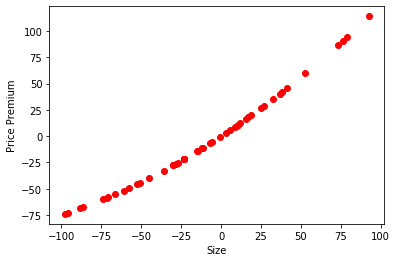

In [11]:
(xlabel, ylabel) = ("Size", "Price Premium")
_= lin.gen_plot(X_lin, y_lin, xlabel, ylabel)

### Nothing better than visualizing !

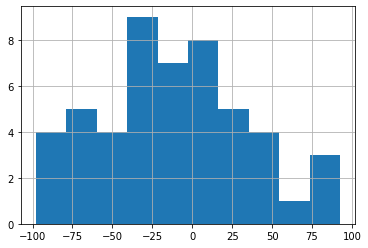

In [12]:
_= df["X"].hist()  # See why Pandas is so convenient ?

# BTW, what's with this "_ = ..." business ?

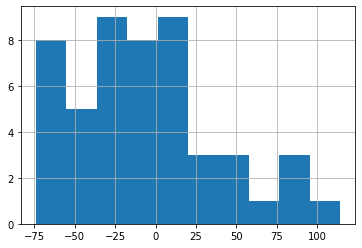

In [13]:
_= df["y"].hist()

#### But if we don't have Pandas, can use Matplotlib

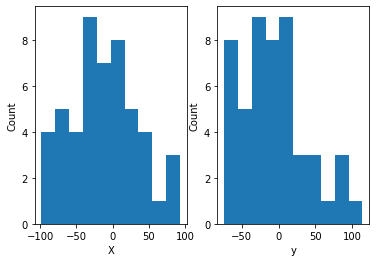

In [14]:
# Use the Object-Oriented interface to Matplotlib, NOT the MATLAB interface
# Create a figure
fig = plt.figure()

# Create a histogram for X.  The figure will be 1 row by 2 columns and the plot for X will be in column 1
ax = fig.add_subplot(121)
_ = ax.hist(X_lin)
_ = ax.set_xlabel("X"); _ = ax.set_ylabel("Count")

# Create a histogram for Y.  The figure will be 1 row by 2 columns and the plot for X will be in column 2
ax = fig.add_subplot(122)
_ = ax.hist(y_lin)
_ = ax.set_xlabel("y"); _ = ax.set_ylabel("Count")


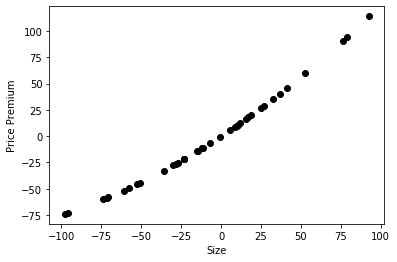

In [15]:
# Plot the target vs one feature
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_train, y_train,  color='black')
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)

Relationship between Size and Price could be linear.

That will be our initial hypothesis

# Recipe Step C: Prepare the data
- Your exploration of the data may have revealed issues that need to be addressed before modeling
    - Dirty data
    - There may be features at vastly different scales; may need to re-scale
    - Need to select or eliminate features
    - Need to create synthetic features
        - How to handle Categorical features ?
        - How to handle non-numeric features, e.g., Text

In the toy example, everything is clean and perfect, so nothing to do just yet.

We will revisit this in the module on Data Transformations.

## Recipe C.1: Cleaning

Our toy problem gave you perfect data (don't get used to this!) so nothing to do.

## Recipe C.2: Handling non-numeric features/targets

Our toy problem involves only numeric data.

## Recipe C.3: Transformations

It's not always the case that the "raw" data is amenable for modelling.

This is where transformations of the raw data come in.

Our EDA suggests that the relationship between target and feature is mostly linear
- we can see a hint of non-linearity
    - we could choose the address this via a transformation
    - but we'll keep it simple for now and forgo transformations

## Recipe C.4: Scaling

The scale of the features and target are problem dependent (area, price in dollars).

We can choose to "redominate" our data into different units if doing so would improve our prediction.
For example, making features/targets
- zero-centered: how far below/above average price
- standardizing: how many standard deviations from mean

There are also some models that *expect* the numeric values to be scaled.

For now, we'll leave our toy problem data unscaled.

# Recipe Step D: Train a model

Training a model is an *iterative process* modelled after the scientfic method
- Select a model (Propose a hypothesis): what is the relatioship between features and target ?
- Fit (Test the hypothesis): run an experiment
- Validation and Cross Validation (High level review of experimental results)
- Error Analysis (Critique the experimental results)

The final step, Error Analysis can suggest strengths and weaknesses of the selected model and lead us
to select an even *better* model.

This leads to iterative improvement of our model.


# Baseline model

Before we begin: how will we know that the model we select has achieved something useful ?

It is helpful to start with a simple (perhaps naive) *baseline model* for purpose of comparison.
- Any more complex model we choose must outperform the baseline

For Regression, a baseline might be
- predict the average (across training examples) of the target

For Classification, a baseline might be
- constant: always predict a single, constant class
- Most Frequent: always predict the classs that occurs most frequently among the target classes in the training examples

You can choose an even more complicted baseline: you choose the hurdle for your complex model to overcome.

## Recipe D.1:Select a model

 We form an hypothesis that relates features to targets.  
 
 The **model** is a tool that implements our hypothesis.
 Various terms are used:
 - hypothesis
 - estimator
 - prediction function
       

An **hypothesis (predictor, estimator)** is a mapping from feature to target
- $\hat{\y} = h_\Theta (\x)$
    - $\hat{\y}$ is the **predicted value**, conditional on given feature vector $\x$
    - $\Theta$ is a  column vector of parameters of our model

Based on our EDA, our initial hypothesis is
$$
h_\Theta (\x) = \Theta^T \x
$$

That is: there is a linear relationship between features $\x$ and target $\y$.

The model we have chosen is called *Linear Regression*

## Step D.2: Fit

Now that we have a hypothesis (model), it's time to run an experiment
- Given the training examples
- "Fit" the model (solve for the optimal $\Theta$ in $\h_\Theta$)
- Obtain predictions
    - training examples

`sklearn` has an *estimator* called `LinearRegression` that solves a hypothesis in the form of
a Linear Regression.

We will have a fuller discussion of the mathematics of the algorithm at a later date.

For now, our objective is to use the estimator to obtain an optimal (relative to Loss $\loss$ we defined for Linear Regression) $\Theta$.

This is called **fitting** the model

We formulate the problem as an optimization: Choose $\Theta$ that minimizes the loss $\loss$
$$
\begin{array}{lll}\\
& \Theta & = & \textrm{argmin}_{\Theta} { \loss } & \\
\end{array}
$$

The loss function $\loss$ for Linear Regression is RMSE
- in this case: the Loss and Performance Metrics are identical
- that will not always be the case


You can explore Linear Regression in depth [in this VanderPlas notebook](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb)

### LinearRegression model in sklearn

In [16]:
# Say it in code

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
_ = regr.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', regr.intercept_, regr.coef_)
print("\nShape of intercept: {i}; shape of coefficients: {c}".format(i=regr.intercept_.shape,
                                                                   c=regr.coef_.shape) )

Coefficients: 
 [4.93224426] [[0.96836946]]

Shape of intercept: (1,); shape of coefficients: (1, 1)


- `regr = linear_model.LinearRegression()` 
    - creates an *unitinitialzed* model object with $\Theta$ undefined
- `_ = regr.fit(X_train, y_train)`
    - fits the model to the training set, setting $\Theta$
-  `y_pred = regr.predict(X_test)`
    - we can use the model to predict once it has been fit
    - since $\Theta$ is defined, we can predict $\Theta^T \x'$
        - for any feature vector $\x'$ (not necessarily from the training or test sets)
        - $\x'_0 = 1$, i.e, the vector has been augmented with a leading feature that is "1"

### Let's Predict !

In [17]:
# Recall: one way to turn a 1D ndarray into 2D is using reshape
np.array([100]).reshape(-1,1)

array([[100]])

In [18]:
# One prediction
t = [100]

# Remember: want a 2D ndarray
t_array = np.array(t).reshape(-1,1)

print("For size {s}, predicted {attr} {d}".format(s=t, attr=ylabel, d=regr.predict(t_array)))

For size [100], predicted Price Premium [[101.76919047]]


In [19]:
# Lots of predictions: predict on entire test set
y_pred = regr.predict(X_test)

<div class="alert alert-block alert-danger">
    <b>Cheating alert:</b> 
    <ul>
    <li>You should use the test set <b>only once</b>, at the end of the process.
    <li>We just looked at the test set !  Not good !
    <li>We will soon learn a way to test, without cheating
    <li>In general, using the test set more than once, at the end of the process, is something to avoid
    </ul>   
</div>

### How did we do ?  Evaluate the Performance Measure on out of sample data

- Measure the performance out of sample
- Interpret the results
    - do the results suggest room for improvement (i.e, the next experiment) ?

In [20]:
# The mean squared error
rmse = np.sqrt( mean_squared_error(y_test,  y_pred))
print("Root Mean squared error: {:.2f}".format( rmse ) )

# Explained variance score: 1 is perfect prediction
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred)) )

Root Mean squared error: 6.86
R-squared: 0.98


What do these numbers mean ?
- Relative to the given test set
    - our price premium predictions are with +/- 7
- Let's visualize the fit

#### Visualize the fit

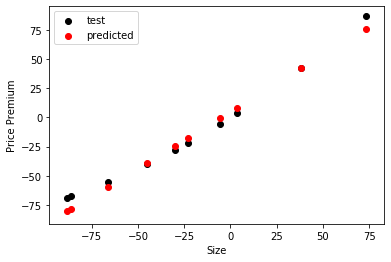

In [21]:
# Plot predicted ylabel (red) and true ylabel (black)
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_test, y_test, color='black', label="test")
_ = ax.scatter(X_test, y_pred, color="red",   label="predicted")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
_ = ax.legend()

Since model is linear, we connect the fitted points into a fitted line

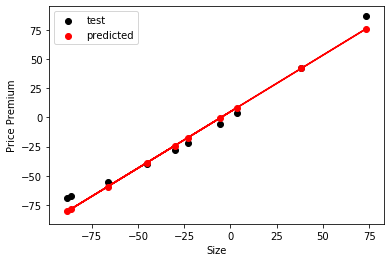

In [22]:
# Plot predicted ylabel (red) and true  (black)
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_test, y_test, color='black', label="test")
_ = ax.scatter(X_test, y_pred, color="red",   label="predicted")

_ = ax.plot(X_test, y_pred, color="red")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
_ = ax.legend()

## Recipe D.3:  Validation and Cross-Validation

- Recall our goal is good, out-of-sample prediction.  And the test set is our benchmark for generalization.
- If we look at the test set in the middle of our process, it will influence our final model.  
- We may thus wind up with a good score on the test set, but generalize poorly to a completely unseen observation.

- It's like seeing the answers to an exam in advance ! Don't do it !  
- You can only look at it *ONCE*, when you're all done, if you want a truly honest indicator of generalization.



### Validation

[Geron notebook](external/PythonDataScienceHandbook/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb#Thinking-about-Model-Validation)

So how can we perform out of sample prediction to evaluate our model ?


- Answer: Split the *training set* into two pieces
    - a smaller training set
    - a *hold-out* piece called the *validation* set
        - the validation set serves a similar role to the test set; it's out of sample
        - it is used to see how well the model generalizes
        - you can use the validation set *many* times (sort of) during your iterative process
            - unlike the test set, which you may look at only once, at the end
        

<table>
 <tr>
        <th><center>Train/Validation/Test split</center></th>
    </tr>
    <tr>
        <td><img src="images/Validation.jpg"</td>
    </tr>
</table>

- This can be painful if the amount of Training data is small to begin with
- We risk "over-using" the Validation data

### Cross-Validation

Splitting into a smaller training set, and a validation set, is a step in the right direction as it allows you to evaluate out of sample predictions without peeking into the test set.

You might still be uncomfortable with the idea of a validation set that is used many times.  Rightly so.
- We can wind up over-fitting to the validation set.  Isn't that cheating too ?
- The smaller training set is smaller -- a problem if we don't have much training data to begin with.
- The validation set is just *one* sample. 
    - How do we know the Performance Measure on this one sample is representative ?
    - Where are the error bars or confidence intervals for this statistic ?
    
Cross-Validation to the rescue !

**K-fold cross-validation**
- Split the training data into $K$ pieces (called *folds*. so K-fold means $K$ pieces).
- Select one fold as the validation set, and use the other $(K-1)$ folds as the smaller training set
    - Fit the model on the smaller training set
    - Evaluate the Performance measure on the fold selected as the validation set
- Repeat the above $(K-1)$ times, using a different fold as the validation set each time.

<table>
 <tr>
        <th><center>Cross Validation/Test split</center></th>
    </tr>
    <tr>
        <td><img src="images/Cross_validation.jpg"</td>
    </tr>
</table>

At the end, you will have fit the model $K$ times, using $K$ different out of sample sets.

This reduces the tendency of training to overfit to a single validation set.

- This gives you $K$ values for the Performance Measure
- These $K$ values form a probability distibution of Performance Measures
- Use this distribution in order to create a "confidence interval" for the Performance Measure
- This is akin to the statistical confidence interval for in-sample estimators

Typically, we report the average of the $K$ Performance Measures as our final Performance Measure.

But it is also valuable to look at the range (e.g., standard deviation) to get an idea of how much it can vary.

A model with a smaller range is more confident that one with a wider range.


This sounds like a lot of work.

Fear not !

sklearn has a function to do this for us: `cross_val_score`

`from sklearn.cross_validation import cross_val_score`

`scores = cross_val_score(model, X, y, cv=5)`
 
This will do $5$-fold cross-validation (`cv=5`) on `model` using training features `X` and targets `y`.

It will return $5$ scores, one per validation fold.

**In general you should be using Cross Validation in Classical ML** in the absence of a good reason not to !
- helps you determine stability of your model's predictions
- once we get to Deep Learning: 
    - training may be so expensive as to preclude the use of Cross Validation
    
Remember: you still have the Test set as the "gold standard"

### Avoid "cheating" in cross-validation

Cross-validation provides a subtle opportunity to "cheat"

$k$-fold cross validation creates $k$ different (train, validation) set splits and the same model is fit and evaluated on each split.

Recall the "No cheating" rule: the test data **must not be used** except at the very end.
- The "Prepare the data" step *may* have looked at (and modified) the entire $\X$
- This occurs *before* the split of $\X$ into a smaller training plus validation set.
- The validation set serves the role of test set
- Thus the smaller training set *may have* been influenced by examples in the validation set

To avoid cheating when using Cross Validation one must
- apply the Prepare the Data operations to the smaller training set of *each split*
    - **not** on the entire training set !
    
This sounds like a lot of work !  We'll give some practical tips when we revisit this topic.

## Recipe D.4:  Error analysis

The Performance Measure is just a summary statistic: 
- one value that summarizes a distribution.

- There is a lot of potentially valuable information lost in the summary.

Let's examine the *individual* errors, rather than the summary, when we fit our "curvy" data set with a simple line.

Coefficients: 
 [4.93224426] [[0.96836946]]


R-squared (test): 0.98
Root Mean squared error (test): 6.86


R-squared (train): 0.98
Root Mean squared error (train): 6.56


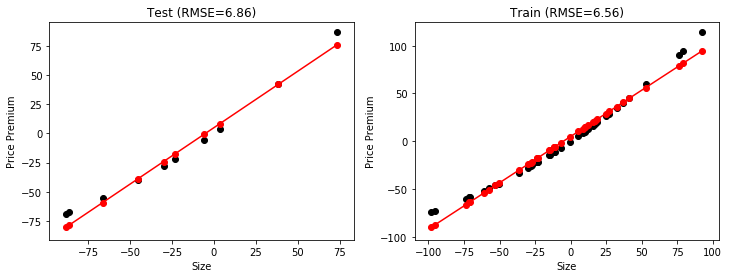

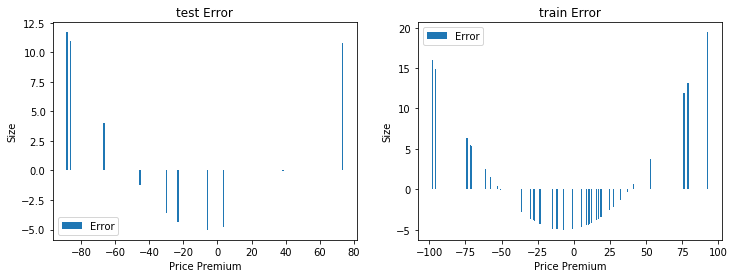

In [23]:
_= lin.regress_with_error(X_lin, y_lin, xlabel=xlabel, ylabel=ylabel)

In [24]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


### What do the errors tell you

- The differences between predictions (red line) and actual (black dots) seems biggest in the tails
- positive errors at the extremes
- negative errors in the center.

Might this be a problem ?


Definitely !

When we learn more about Linear Regression, we will discover that this pattern of errors violates one
of the statistical assumptions behind the model (i.e., for fitting on the training set).

Moreover, the errors are biased in that they are a function of the feature magnitude.  This may not be
a satisfactory prediction for our particular use case.


As you can see, lurking beneath a pretty good Performance Measure (0.91) is a distinct pattern in the
errors.

This is something that we should definitely fix.

This is where the iterative improvement comes in
- Propose a new experiment that corrects the current model's deficiencies




We will defer doing so for a moment, in order to finish our presentation of the Recipe.

For now: suffice it to say that you sometimes learn more from your failures than from your successes.

**Bottom line** 
- Don't be satisfied with a summary statistic
- There is valuable information in the errors: use it to improve your model


## Error analysis: test versus training

We can hardly expect to avoid problems on unseen data if those problems are already present in training.

Moreover, if the Performance Metric is too different on the two data sets, it may be indicative of a problem.

We will revisit this in the section on Bias versus Variance.

So, although our ultimate objective is out of sample prediction, it is worthwhile to extend the analysis
to in-sample (training) data as well.



### Machine Learning versus "Statistics"

- In Machine Learning, the Performance Metric is evaluated out of sample
- In Statistics, we often evaluate this measure in sample

Is Statistics just Machine Learning where the Test and Training sets are the same ?

Let's look at how well we did in sample

In [25]:
# Lots of predictions: predict on entire TRAINING set
y_pred_train = regr.predict(X_train)

# The mean squared error
rmse_train = np.sqrt( mean_squared_error(y_train,  y_pred_train))
print("(train) Root Mean squared error: {:.2f}".format( rmse_train ) )

# Explained variance score: 1 is perfect prediction
print("(train) R-squared: {:.2f}".format(r2_score(y_train, y_pred_train)) )

(train) Root Mean squared error: 6.56
(train) R-squared: 0.98


- In sample RMSE, $R^2$ similar to out of sample
 
- The larger errors in the tails shows up in the taining set too

If you don't do well in-sample, it's hard to imagine that you'll do better out of sample.

So it is often helpful to look at errors in the training sample.

Stated another way
- Statistics is often concerned with *explanation* (of the past)
- Machine Learning is concerned with *prediction* (of the future_

Before we dismiss Statistics, it is a highly disciplined field that we can learn from
- emphasis on *confidence intervals*
    - everything is an estimate (e.g., our parameters)
    - what is the range of likely values
        
This is sadly missing from parts of Machine Learning
- particularly Deep Learning (it's just too expensive to compute confidence intervals)
- Cross Validation can be used as a proxy for confidence intervals
    - we have multiple out of sample "folds"
    - which gives us a *distribution* (across folds) of Performance metrics, parameters, etc.
    - the distribution tell us the spread of values just like a confidence interval

# Recipe Step E: Fine-tuning your model

Once we are satisfied with our Hypothesis, there may be some "knobs" to adjust for even better results

- Hyper-parameters
- GridSearch
- Ensembles

- We will visit this later

# Improving the model

Our error analysis of the toy problem suggested that a straight line was perhaps not the best fit
- positive errors in the extremes
- negative errors in the center

Perhaps a "curve" would be a better hypothesis ?
What if our data is not linear ? 

We will show how to improve this model in the lecture on Linear Regression.


# Recap

- We learned our first model for a *regression* task
    - previously learned the KNN model for a *classification* task
- Importance of feature engineering
    - if all you have is a linear model: transform your data to make it linear
- Cross validation: out of sample analysis without cheating; confidence intervals
- Importance of Error Analysis
- The `sklearn` API

## The sklearn API

fit, transform

fit_transform

predict

[Scikit-learn cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

# What does this have to do with Finance ?

- Stock market "beta": how much does a stock move, for a 1% move in the index ?
    - Typically calcuated using LinearRegression, with some window
    - But who says this is the "best" (gives best prediction) window ?
        - we can address this in Cross-Validation
- Multi-factor models
    - LinearRegression with multiple regressors

In [26]:
print("Done !")

Done !
